In [6]:
import sys
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

src = Path('../src').resolve()
if src not in sys.path:
    sys.path.append(src)
    
# Force reload of project files
import data, train, models, evaluate, metrics
importlib.reload(data)
from data import DataLoader

data_dir = Path("../data/wqp")

sequence_length = 30
batch_size = 1024

with open(data_dir / 'site_list.txt', 'r') as file:
    basin_list = file.readlines()
    basin_list = [site.strip() for site in basin_list]

data_params = {'data_dir': data_dir,
               'basins': basin_list,
               'features_dict': {'daily':['grfr_q'],
                                 'irregular':['Blue','Green','Red','Nir','Swir1','Swir2']},
               'target': 'ssc',
               'time_slice': slice('1979-01-01', '2018-12-31'),
               'split_time': np.datetime64('2010-01-01'),
               'batch_size': batch_size,
               'sequence_length': sequence_length,
               'discharge_col': 'grfr_q'}

dataloader = DataLoader(**data_params)

In [13]:
batch['x_di']

Array([[[        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan,         nan,
                 nan,         nan],
  

In [18]:
importlib.reload(models)
importlib.reload(train)
from models import TAPLSTM, EALSTM, LSTM
from train import make_step, lr_dict_scheduler

daily_in_size = len(data_params['features_dict']['daily'])
irregular_in_size = len(data_params['features_dict']['irregular'])
static_in_size = dataloader.x_s[basin_list[0]].shape[0]
out_size = 1
hidden_size = 64
dropout = 0.2
key = jax.random.PRNGKey(0)

num_epochs =  250
lr_schedule = {0: 0.05,
               5: 0.01,
               50: 0.005,
               150: 0.001}

model = TAPLSTM(daily_in_size, irregular_in_size, static_in_size, out_size, hidden_size, key=key, dropout=dropout)
# model = LSTM(daily_in_size, output_size, hidden_size, key=key, dropout=dropout)
# model = EALSTM(daily_in_size, static_in_size, output_size, hidden_size, key=key, dropout=dropout)

# Initialize optimizer 
current_lr = lr_dict_scheduler(0, lr_schedule)
optim = optax.adam(current_lr)
opt_state = optim.init(model)

dataloader.train = True

# Training loop
loss_list = []
# pbar = trange(num_epochs, desc="Epoch")
# for epoch in pbar:
for epoch in range(num_epochs):
    # jax.profiler.start_trace(f"/Users/Ted/Documents/GitHub/tss-ml/tmp/profile_{epoch}") 

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    current_lr = lr_dict_scheduler(epoch, lr_schedule)
    optim = optax.adam(current_lr)
    total_loss = 0
    num_batches = 0
    for basins, _, batch in pbar:
        loss, model, opt_state = make_step(model, batch, opt_state, optim,
                                           loss_name="mse")
                                           # max_grad_norm=3,
                                           # l2_weight = 1E-4)
        total_loss += loss
        num_batches += 1
        pbar.set_postfix_str(f"Loss: {total_loss/num_batches:.4f}")
            
    current_loss = total_loss / num_batches
    loss_list.append(current_loss)
    # pbar.set_postfix_str(f"Loss: {current_loss:.4f}")

    # jax.profiler.stop_trace()

plt.plot(loss_list)
plt.ylabel("Loss")
plt.xlabel("Epoch")

Epoch 0:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/263 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/263 [00:00<?, ?it/s]

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function scan_fn at /Users/Ted/Documents/GitHub/tss-ml/src/models.py:297 for scan. This value became a tracer due to JAX operations on these lines:

  operation a:bool[192,6] = eq b c
    from line /Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/equinox/_tree.py:244:23 (_array_equal)

  operation a:bool[] = and b c
    from line /Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/equinox/_tree.py:312:33 (tree_equal)

  operation a:bool[192,64] = eq b c
    from line /Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/equinox/_tree.py:244:23 (_array_equal)

  operation a:bool[192] = eq b c
    from line /Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/equinox/_tree.py:244:23 (_array_equal)

  operation a:bool[64,197] = eq b c
    from line /Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/equinox/_tree.py:244:23 (_array_equal)

(Additional originating lines are not shown.)
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [251]:
from metrics import get_all_metrics
from matplotlib.dates import YearLocator, DateFormatter
import datetime 

importlib.reload(evaluate)
from evaluate import predict

results = predict(model, dataloader)

  0%|          | 0/5034 [00:00<?, ?it/s]

/Users/Ted/Documents/GitHub/tss-ml/src/metrics.py:13: RuntimeWarning: Mean of empty slice
  return np.nanmean((y - y_hat)**2)
/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/Ted/Library/Caches/pypoetry/virtualenvs/tssml-WvnpDPLB-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/Ted/Library/Caches/pypoetry/v

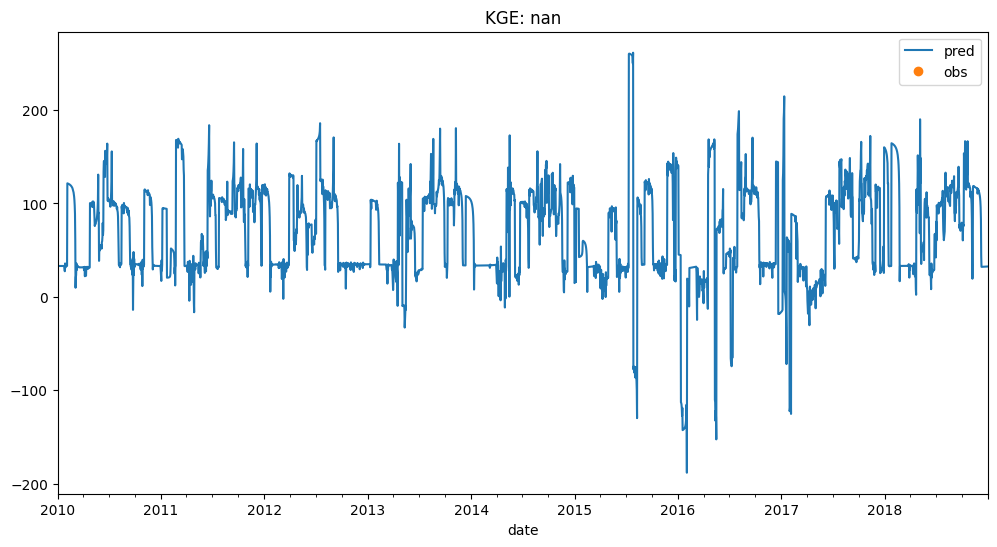

In [257]:
basin_id = np.random.choice(basin_list)
basin_results = results[results.index.get_level_values('basin')==str(basin_id)]
basin_results = basin_results.droplevel('basin')
metrics = get_all_metrics(basin_results['obs'],basin_results['pred'])

# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
basin_results['pred'].plot(ax=ax)
basin_results['obs'].plot(ax=ax,linestyle='None',marker='o')

plt.title(f"KGE: {metrics['kge']:0.4f}")
plt.legend()
plt.show()

In [39]:
basin_results

obs      pred
basin          date                     
sag_daily_data 2020-01-01  NaN  0.027141
               2020-01-02  NaN  0.027141
               2020-01-03  NaN  0.027141
               2020-01-04  NaN  0.027141
               2020-01-05  NaN  0.027141
...                        ...       ...
               2022-11-10  NaN  0.027141
               2022-11-11  NaN  0.027141
               2022-11-12  NaN  0.027141
               2022-11-13  NaN  0.027141
               2022-11-14  NaN  0.027141

[1049 rows x 2 columns]